In [1]:
import pandas as pd
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

In [2]:
meta_data = 'meta_data.json'
df = pd.read_json(meta_data)

In [3]:
df

,database,url,title,authors,journal,citations,publish_date,keywords,doi,journal_impact_factor
0,ieeexplore,https://ieeexplore.ieee.org/document/6027518,A visualization and modeling tool for security...,"[Reijo M. Savola ;, Petri Heinonen]",2011 Information Security for South Africa,10.0,2011,"[Measurement, Visualization, Authentication, D...",10.1109/ISSA.2011.6027518,NaN
1,sciencedirect,https://www.sciencedirect.com/science/article/...,Information security requirements – Interpreti...,"[{'surname': 'Gerber', 'first_name': 'Mariana'...",Computers & Security,21.0,5–6,"[Information security, Information security ma...",https://doi.org/10.1016/j.cose.2008.07.009,3.062
2,ieeexplore,https://ieeexplore.ieee.org/document/7166125,Cyber security operations centre: Security mon...,[Cyril Onwubiko],2015 International Conference on Cyber Situati...,6.0,2015,"[Monitoring, Business, Computer crime, System-...",10.1109/CyberSA.2015.7166125,NaN
3,sciencedirect,https://www.sciencedirect.com/science/article/...,Security Management Standards: A Mapping,"[{'surname': 'Haufe', 'first_name': 'Knut'}, {...",Procedia Computer Science,NaN,2016,"[Information Security, ISMS, Mapping, Processe...",https://doi.org/10.1016/j.procs.2016.09.221,NaN
4,sciencedirect,https://www.sciencedirect.com/science/article/...,Mapping the field of software life cycle secur...,"[{'surname': 'Morrison', 'first_name': 'Patric...",Information and Software Technology,3.0,2018,"[Metrics, Measurement, Security]",https://doi.org/10.1016/j.infsof.2018.05.011,2.921
...,...,...,...,...,...,...,...,...,...,...
137,sciencedirect,https://www.sciencedirect.com/science/article/...,A survey of security issues for cloud computing,"[{'surname': 'Khan', 'first_name': 'Minhaj Ahm...",Journal of Network and Computer Applications,77.0,2016,"[Cloud security, Cloud computing, Denial-of-se...",https://doi.org/10.1016/j.jnca.2016.05.010,5.273
138,ieeexplore,https://ieeexplore.ieee.org/document/7921989,A framework for measurability of security,"[Seraj Fayyad ;, Josef Noll]",2017 8th International Conference on Informati...,1.0,2017,"[Security, Measurement, Databases, Privacy, Sy...",10.1109/IACS.2017.7921989,NaN
139,ieeexplore,https://ieeexplore.ieee.org/document/5467019,A Formal Approach Enabling Risk-Aware Business...,"[Simon Tjoa ;, Stefan Jakoubi ;, Gernot Goluch...",IEEE Transactions on Services Computing,15.0,2010,"[Security, Unified modeling language, Risk man...",10.1109/TSC.2010.17,5.707
140,ieeexplore,https://ieeexplore.ieee.org/document/7367050,The effectiveness of corporate culture toward ...,"[Abdullah Almubark ;, Nobutoshi Hatanaka ;, Os...",2015 World Congress on Information Technology ...,133.0,2015,"[Decision support systems, Information securit...",10.1109/WCITCA.2015.7367050,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 10 columns):
database                 142 non-null object
url                      142 non-null object
title                    142 non-null object
authors                  142 non-null object
journal                  142 non-null object
citations                135 non-null float64
publish_date             140 non-null object
keywords                 142 non-null object
doi                      139 non-null object
journal_impact_factor    51 non-null float64
dtypes: float64(2), object(8)
memory usage: 11.2+ KB


In [5]:
# Optimizes the database column to categorys
df["database"] = df["database"].astype('category')

# Reassigned the publish date
df["publish_date"][1] = 2008
df["publish_date"][6] = 2018
df["publish_date"][17] = 2015
df["publish_date"][20] = 2018
df["publish_date"][62] = 2018
df["publish_date"][25] = 2013
df["publish_date"][31] = 2017
df["publish_date"][39] = 2010
df["publish_date"][53] = 2019
df["publish_date"][74] = 2017
df["publish_date"][80] = 2010
df["publish_date"][89] = 2018
df["publish_date"][110] = 2012
df["publish_date"][135] = 2017
df["publish_date"][87] = 2018

# All Integers for column publish date
df["publish_date"] = df["publish_date"].astype('int')
df["citations"].fillna(0, inplace=True)
df["citations"] = df["citations"].astype('int')
df["journal_impact_factor"].fillna(0, inplace=True)

# Rename columns
df.rename(columns={"publish_date": "year", "journal_impact_factor": "impact_factor"}, inplace=True)

# Drop duplicated papers
df = df.drop_duplicates("doi")

# Replacing list of dicts in authors column for sciencedirect papers with list of authors names
scidir_mask = df["database"] == 'sciencedirect'
f = lambda x: [f"{y['first_name']} {y['surname']}" for y in x]
df.loc[scidir_mask, 'authors'] = df.loc[scidir_mask, 'authors'].apply(f)


# Striping the keywords from whitespaces
keyword_striping = lambda x: [keyw.strip(' ') for keyw in x]
df["keywords"] = df.loc[:, "keywords"].apply(keyword_striping)
               
# Dividing keywords into multiple columns:
key_func = lambda x: pd.Series({"keywords{}".format(i):
    x.keywords[i] for i in range(len(x.keywords))})
df = pd.concat([df.apply(key_func,axis=1), df],axis=1)              
                   
                   
# Striping the authors names from whitespaces and semicolons ';'
authors_function = lambda x: [auth.strip('; ') for auth in x]
df["authors"] = df.loc[:, "authors"].apply(authors_function)
               
# Dividing authors into multiple authors columns:
f =  lambda x: pd.Series({"author{}".format(i):
                          x.authors[i] for i in range(len(x.authors))})

df = pd.concat([df.apply(f,axis=1), df],axis=1)
               
# Removing therefore the original "authors" axis
df = df.drop(["authors", "keywords", "doi", "url"], axis=1)
               
i_vals_to_drop = df.loc[df["database"].eq('sciencedirect') & df["impact_factor"].eq(0)].index
df.drop(i_vals_to_drop, inplace=True)

/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_lau

In [6]:
df.drop(["url", "database", "citations", "keywords", "impact_factor"], axis = 1, inplace=True)
df.reset_index(drop=True)
function = lambda x: '; '.join(x)
df["authors"] = df["authors"].apply(function)
df

/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,title,authors,journal,year,doi
0,A visualization and modeling tool for security...,Reijo M. Savola; Petri Heinonen,2011 Information Security for South Africa,2011,10.1109/ISSA.2011.6027518
1,Information security requirements – Interpreti...,Mariana Gerber; Rossouw von Solms,Computers & Security,2008,https://doi.org/10.1016/j.cose.2008.07.009
2,Cyber security operations centre: Security mon...,Cyril Onwubiko,2015 International Conference on Cyber Situati...,2015,10.1109/CyberSA.2015.7166125
4,Mapping the field of software life cycle secur...,Patrick Morrison; David Moye; Rahul Pandita; L...,Information and Software Technology,2018,https://doi.org/10.1016/j.infsof.2018.05.011
5,The trustworthy computing security development...,S. Lipner,20th Annual Computer Security Applications Con...,2004,10.1109/CSAC.2004.41
...,...,...,...,...,...
137,A survey of security issues for cloud computing,Minhaj Ahmad Khan,Journal of Network and Computer Applications,2016,https://doi.org/10.1016/j.jnca.2016.05.010
138,A framework for measurability of security,Seraj Fayyad; Josef Noll,2017 8th International Conference on Informati...,2017,10.1109/IACS.2017.7921989
139,A Formal Approach Enabling Risk-Aware Business...,Simon Tjoa; Stefan Jakoubi; Gernot Goluch; Ger...,IEEE Transactions on Services Computing,2010,10.1109/TSC.2010.17
140,The effectiveness of corporate culture toward ...,Abdullah Almubark; Nobutoshi Hatanaka; Osamu U...,2015 World Congress on Information Technology ...,2015,10.1109/WCITCA.2015.7367050


In [7]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [8]:
print(df.head().to_latex(longtable=True))

\begin{longtable}{llllrl}
\toprule
{} &                                              title &                                            authors &                                            journal &  year &                                           doi \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
0 &  A visualization and modeling tool for security... &                    Reijo M. Savola; Petri Heinonen &         2011 Information Security for South Africa &  2011 &                     10.1109/ISSA.2011.6027518 \\
1 &  Information security requirements – Interpreti... &                  Mariana Gerber; Rossouw von Solms &                               Computers \& Security &  2008 &    https://doi.org/10.1016/j.cose.2008.07.009 \\
2 &  Cyber security operations centre: Security mon... &                                     Cyril Onwubiko &  2015 International Conference on Cyber Situati... &  2015 &              

In [9]:
df.head(2).to_latex()

'\\begin{tabular}{llllrl}\n\\toprule\n{} &                                              title &                            authors &                                     journal &  year &                                         doi \\\\\n\\midrule\n0 &  A visualization and modeling tool for security... &    Reijo M. Savola; Petri Heinonen &  2011 Information Security for South Africa &  2011 &                   10.1109/ISSA.2011.6027518 \\\\\n1 &  Information security requirements – Interpreti... &  Mariana Gerber; Rossouw von Solms &                        Computers \\& Security &  2008 &  https://doi.org/10.1016/j.cose.2008.07.009 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [6]:
df.to_csv('citations.csv')

In [7]:
df.sort_values(by="citations", ascending=False).head(15).reset_index()

,index,database,url,title,authors,journal,citations,year,keywords,doi,impact_factor
0,126,ieeexplore,https://ieeexplore.ieee.org/document/7503287,Building an effective and efficient continuous...,"[Mahesh Bang, Himanshu Saraswat]",2016 International Conference On Cyber Situati...,817,2016,"[Security, Internet, Performance analysis, Tes...",10.1109/CyberSA.2016.7503287,0.000
1,130,ieeexplore,https://ieeexplore.ieee.org/document/8615162,Educating and Raising Awareness on Cyber Secur...,"[Hussain Aldawood, Geoffrey Skinner]",NaJ,773,2018,"[Organizations, Phishing, Training, social eng...",10.1109/TALE.2018.8615162,0.000
2,50,ieeexplore,https://ieeexplore.ieee.org/document/7473537,A design review: Concepts for mitigating SQL i...,"[Ed Pearson, Cindy L. Bethel]",2016 4th International Symposium on Digital Fo...,562,2016,"[Computer security, Software, Computer science...",10.1109/ISDFS.2016.7473537,0.000
3,76,ieeexplore,https://ieeexplore.ieee.org/document/7335053/k...,A formal qualitative risk management approach ...,"[Bessy Mahopo, Hanifa Abdullah, Mathias Mujinga]",2015 Information Security for South Africa (ISSA),503,2015,[],10.1109/ISSA.2015.7335053,0.000
4,10,ieeexplore,https://ieeexplore.ieee.org/document/8443131,Vulnus: Visual Vulnerability Analysis for Netw...,"[Marco Angelini, Graziano Blasilli, Tiziana Ca...",IEEE Transactions on Visualization and Compute...,486,2018,"[Security, Bars, Measurement, Visual analytics...",10.1109/TVCG.2018.2865028,3.780
5,41,ieeexplore,https://ieeexplore.ieee.org/document/5198449/k...,A unified framework for it security - analysis...,[Tony Dyhouse],Engineering & Technology,428,2009,[],10.1049/et.2009.1112,0.000
6,66,ieeexplore,https://ieeexplore.ieee.org/document/6845061,Industrial cyber security solutions for the co...,[Luis Parrondo],IET Seminar on Cyber Security for Industrial C...,417,2014,[],10.1049/ic.2014.0012,0.000
7,100,ieeexplore,https://ieeexplore.ieee.org/document/7588825,Evaluation of Network Risk Using Attack Graph ...,"[Santosh Kumar, Anuradha Negi, Keshav Prasad, ...","2016 IEEE 14th Intl Conf on Dependable, Autono...",406,2016,"[Measurement, Databases, Computers, Protocols,...",10.1109/DASC-PICom-DataCom-CyberSciTec.2016.30,0.000
8,44,ieeexplore,https://ieeexplore.ieee.org/document/7542343,Data-mining a mechanism against cyber threats:...,"[Shipra Ravi Kumar, J. S. Jassi, Suman Avdhesh...",2016 International Conference on Innovation an...,400,2016,"[Data mining, Clustering algorithms, Computer ...",10.1109/ICICCS.2016.7542343,0.000
9,94,ieeexplore,https://ieeexplore.ieee.org/document/8085770,Towards visual analytics tasks for the securit...,"[Evgenia S. Novikova, Yana A. Bekeneva, Andrey...","2017 International Conference ""Quality Managem...",344,2017,"[Visual analytics, Data visualization, Informa...",10.1109/ITMQIS.2017.8085770,0.000


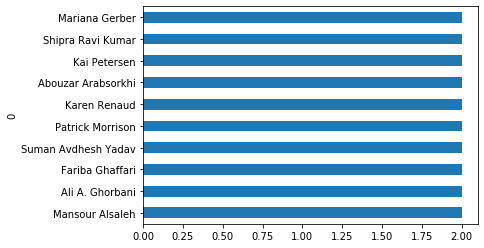

In [6]:
auth_col_list = list(df.columns[:6])
authdf = pd.DataFrame(df[auth_col_list])
authindex = pd.DataFrame(authdf.stack())
authindex.groupby([0]).size().sort_values().tail(10).plot(kind='barh')
#auth_series = pd.Series(df[auth_col_list].values.ravel()).dropna()
#auth_series

In [7]:
df.columns

Index(['author0', 'author1', 'author2', 'author3', 'author4', 'author5',
       'keywords0', 'keywords1', 'keywords10', 'keywords11', 'keywords12',
       'keywords13', 'keywords14', 'keywords15', 'keywords16', 'keywords17',
       'keywords18', 'keywords19', 'keywords2', 'keywords20', 'keywords21',
       'keywords3', 'keywords4', 'keywords5', 'keywords6', 'keywords7',
       'keywords8', 'keywords9', 'database', 'title', 'journal', 'citations',
       'year', 'impact_factor'],
      dtype='object')

In [7]:
ieee = df[df["database"].eq('ieeexplore')]
ieee.rename({'year': 'Jahr', 'citations': 'Zitierungen'}, axis=1, inplace=True)
ieee_df = ieee[["Jahr", "Zitierungen"]]
sd = df[df["database"].eq('sciencedirect')]
sd.rename({'year': "Jahr", "citations": "Zitierungen"}, axis=1, inplace=True)
sd_df = sd[["Jahr", "Zitierungen"]]

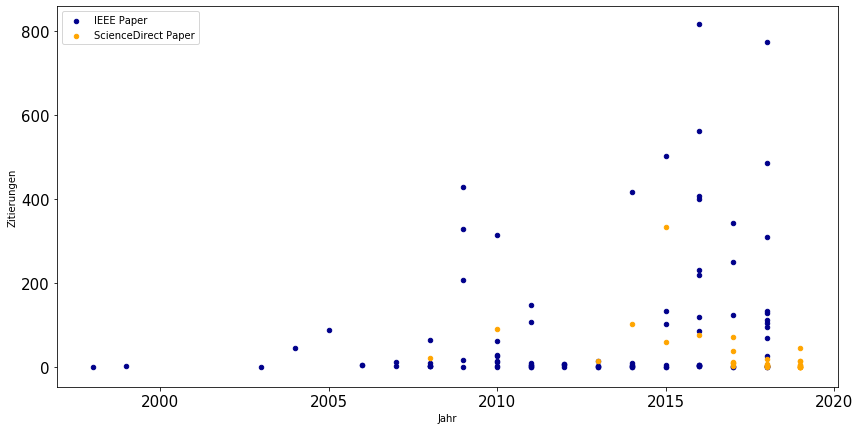

In [9]:
ax = ieee_df.plot(kind='scatter', x="Jahr", y="Zitierungen", label='IEEE Paper', color='DarkBlue')
sd_df.plot(kind='scatter', x='Jahr', y='Zitierungen', color='orange', label='ScienceDirect Paper', ax=ax, figsize=(14,7), fontsize=15)

In [8]:
# Scatterplot
# X: highest impact factor
# Y: Impact factor, ascending

ax = df[["impact_factor", "year", "database" == 'ieeexplore']].plot(kind='scatter')

# df[["impact_factor", "year"]].plot(kind='scatter', x='year', y='impact_factor')

KeyError: '[False] not in index'

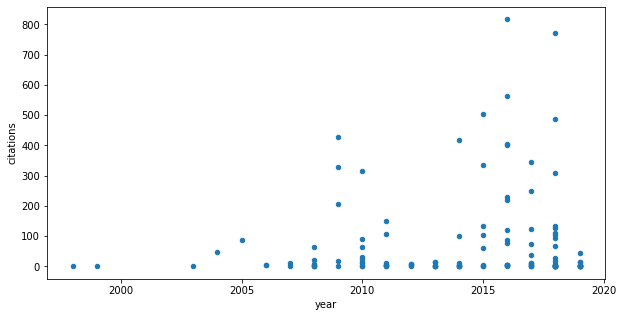

In [9]:
# Scatterplot citations and year
# X: year
# Y: Citations

df[["citations", "year", "database"]].plot(kind='scatter', x='year', y='citations', figsize=(10,5))

In [10]:
# New DataFrame ONLY REAL Papers
ndf = df[["citations", "title", "journal", "database", "year", "impact_factor"]]
df.loc[df["impact_factor"] > 0].sort_values(by="citations", ascending=False)

,author0,author1,author2,author3,author4,author5,keywords0,keywords1,keywords10,keywords11,...,keywords6,keywords7,keywords8,keywords9,database,title,journal,citations,year,impact_factor
10,Marco Angelini,Graziano Blasilli,Tiziana Catarci,Simone Lenti,Giuseppe Santucci,NaN,Security,Bars,Attack Graph,Vulnerability triage and management,...,Network security,Vulnerability analysis,CVE,CVSS,ieeexplore,Vulnus: Visual Vulnerability Analysis for Netw...,IEEE Transactions on Visualization and Compute...,486,2018,3.780
108,Kai Petersen,Sairam Vakkalanka,Ludwik Kuzniarz,NaN,NaN,NaN,Systematic mapping studies,Software engineering,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Guidelines for conducting systematic mapping s...,Information and Software Technology,334,2015,2.921
24,Hadi Shiravi,Ali Shiravi,Ali A. Ghorbani,NaN,NaN,NaN,Data visualization,Security,NaN,NaN,...,IP networks,Information visualization,network security visualization,visualization techniques.,ieeexplore,A Survey of Visualization Systems for Network ...,NaJ,107,2011,3.780
102,Ulrik Franke,Joel Brynielsson,NaN,NaN,NaN,NaN,Situational awareness,Cyber security,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Cyber situational awareness – A systematic rev...,Computers & Security,102,2014,3.062
80,Daniel Mellado,Carlos Blanco,Luis E. Sánchez,Eduardo Fernández-Medina,NaN,NaN,Security requirements,Security requirements engineering,NaN,NaN,...,Systematic review,NaN,NaN,NaN,sciencedirect,A systematic review of security requirements e...,Computer Standards & Interfaces,92,2010,2.441
137,Minhaj Ahmad Khan,NaN,NaN,NaN,NaN,NaN,Cloud security,Cloud computing,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,A survey of security issues for cloud computing,Journal of Network and Computer Applications,77,2016,5.273
31,Ashish Singh,Kakali Chatterjee,NaN,NaN,NaN,NaN,Cloud computing,Cloud framework,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Cloud security issues and challenges: A survey,Journal of Network and Computer Applications,73,2017,5.273
84,Omar H. Alhazmi,Yashwant K. Malaiya,NaN,NaN,NaN,NaN,Operating systems,Security,Operating systems,security,...,Linux,Software systems,Life testing,System testing,ieeexplore,Application of Vulnerability Discovery Models ...,IEEE Transactions on Reliability,64,2008,2.888
132,Noam Ben-Asher,Cleotilde Gonzalez,NaN,NaN,NaN,NaN,Cyber security,Knowledge,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Effects of cyber security knowledge on attack ...,Computers in Human Behavior,61,2015,4.306
134,Wenjun Xiong,Robert Lagerström,NaN,NaN,NaN,NaN,Threat modeling,Literature review,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Threat modeling – A systematic literature review,Computers & Security,46,2019,3.062


In [11]:
df.sort_values(by="citations", ascending=False)

,author0,author1,author2,author3,author4,author5,keywords0,keywords1,keywords10,keywords11,...,keywords6,keywords7,keywords8,keywords9,database,title,journal,citations,year,impact_factor
126,Mahesh Bang,Himanshu Saraswat,NaN,NaN,NaN,NaN,Security,Internet,Security Training,DAST,...,Business,Application Security,Web Application Security Assessment,Security Metrics,ieeexplore,Building an effective and efficient continuous...,2016 International Conference On Cyber Situati...,817,2016,0.000
130,Hussain Aldawood,Geoffrey Skinner,NaN,NaN,NaN,NaN,Organizations,Phishing,NaN,NaN,...,cyber security awareness,information security awareness,NaN,NaN,ieeexplore,Educating and Raising Awareness on Cyber Secur...,NaJ,773,2018,0.000
50,Ed Pearson,Cindy L. Bethel,NaN,NaN,NaN,NaN,Computer security,Software,information security,cyber security,...,SQL injection attack mitigation,SQL injection attack prevention,Human-computer interaction,software security,ieeexplore,A design review: Concepts for mitigating SQL i...,2016 4th International Symposium on Digital Fo...,562,2016,0.000
76,Bessy Mahopo,Hanifa Abdullah,Mathias Mujinga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,ieeexplore,A formal qualitative risk management approach ...,2015 Information Security for South Africa (ISSA),503,2015,0.000
10,Marco Angelini,Graziano Blasilli,Tiziana Catarci,Simone Lenti,Giuseppe Santucci,NaN,Security,Bars,Attack Graph,Vulnerability triage and management,...,Network security,Vulnerability analysis,CVE,CVSS,ieeexplore,Vulnus: Visual Vulnerability Analysis for Netw...,IEEE Transactions on Visualization and Compute...,486,2018,3.780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Iman Sharafaldin,Arash Habibi Lashkari,Ali A. Ghorbani,NaN,NaN,NaN,Information visualization,Network attacks,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,An evaluation framework for network security v...,Computers & Security,1,2019,3.062
89,Michael Ettredge,Feng Guo,Yijun Li,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Trade secrets and cyber security breaches,Journal of Accounting and Public Policy,0,2018,2.269
16,Orestis Mavropoulos,Haralambos Mouratidis,Andrew Fish,Emmanouil Panaousis,NaN,NaN,IoT Security,Security requirements,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Apparatus: A framework for security analysis i...,Ad Hoc Networks,0,2019,3.490
85,Yang Lu,Minghui Zhu,NaN,NaN,NaN,NaN,Cyber-physical systems,Privacy,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,A control-theoretic perspective on cyber-physi...,Annual Reviews in Control,0,2019,4.759


In [12]:
list(df.columns[0:6])

['author0', 'author1', 'author2', 'author3', 'author4', 'author5']

In [13]:
# Melting all author columns into one column
melt_auth_df = df[list(df.columns[0:6])].melt(var_name='auth_id').set_index('auth_id')
melt_auth_df.dropna().groupby('value').size().sort_values(ascending=False)

value
Mariana Gerber         2
Shipra Ravi Kumar      2
Kai Petersen           2
Abouzar Arabsorkhi     2
Karen Renaud           2
                      ..
Nebojša Gvozdenović    1
Neeraj Kumar           1
Nicolas Vavasseur      1
Noam Ben-Asher         1
A. Hunstad             1
Length: 350, dtype: int64

**Keywords**

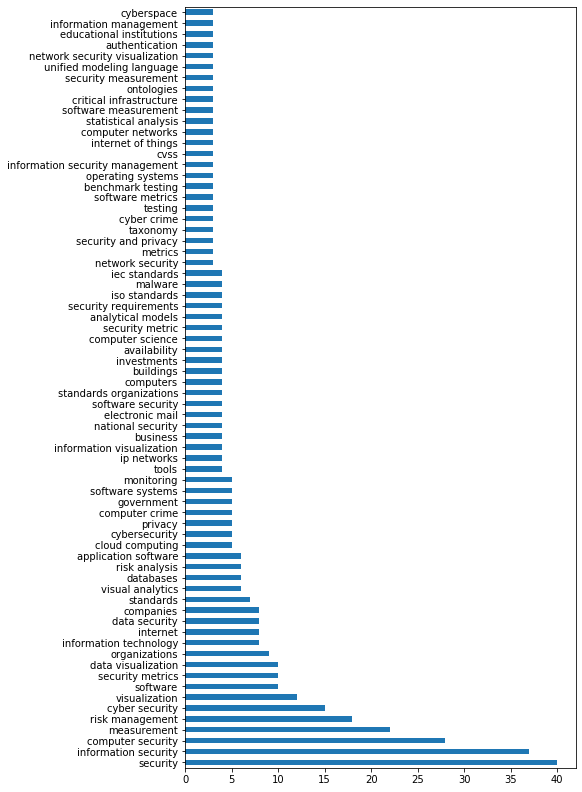

In [14]:
# Get the most used keywords

# Combine the keywordcolumns into one series
#Melting!!
# Search for the most used one 

melt_key = df[list(df.columns[6:28])].melt().drop("variable", axis=1)
melt_df = melt_key["value"].dropna().str.lower()
melt_df.value_counts().head(70).plot(kind='barh', figsize=(7, 14))
#melt_70_dict = melt_df.value_counts().head(70).to_dict()

#WordCloud(background_color="black").generate_from_frequencies(frequencies=melt_70_dict)

#melt_df.plot(kind='barh', figsize=(7, 14))
#.groupby("value").size().sort_values(ascending=False).head(50).plot(kind='barh', figsize=(7,12))

In [15]:
keywords_count = melt_df.value_counts()
keywords_count.head(50)


# Show all keywords that contain 'security'
def show_keywords_with_security_in_them(series,search_pattern):
    for elem in series:
        if search_patter in elem:
            print(elem)
        else:
            continue

# Show all keywords that contain 'security' not at the start
# At least once character must be before 'security'

# Regex security not at first position
def keywords_security_not_at_first_pos(series, search_pattern):
    re_sec = re.compile(r'.+security')
    for elem in series:
        if re_sec.search(elem):
            print(elem)
        else:
            continue
        
# Get it-security and it security and combine them into one
# get the corresponding value and add them up
# remove whitespaces and seperating spaces.
# Then add up again
melt_key = df[list(df.columns[6:28])].melt().drop("variable", axis=1)
melt_df = melt_key["value"].dropna().str.lower()
melt_rep_df = melt_df.str.replace(' ', '').str.replace('-', '')
# melt_rep_df.value_counts().head(70).plot(kind='barh', figsize=(7,14))

In [16]:
# Words to count together
# security metric & security metrics & metrics & metrics
sec_met_words = ['security metric', 'security metrics', 'metric', 'metrics']
# get all needed rows to combine
# 

m_values = melt_df.value_counts()
def find_all_values_in_df(word_list, some_df):
    found_elem = []
    for elem in word_list:
        f_elem = some_df.loc[elem]
        found_elem.append(f_elem)
    return found_elem

def delete_index_in_df(word_list, some_df):
    return some_df.drop(word_list)

sec_mec_counts = find_all_values_in_df(sec_met_words, m_values)
without_sec_mec = delete_index_in_df(sec_met_words, m_values)
without_sec_mec
# Get positions of words and values
# delete positions
# create new position 'security metrics'


security                                     40
information security                         37
computer security                            28
measurement                                  22
risk management                              18
                                             ..
security information and event management     1
task analysis                                 1
high level metrics visualization              1
complex environments                          1
management model                              1
Name: value, Length: 625, dtype: int64

In [17]:
df.loc[df["database"].eq('sciencedirect') & df["journal"].eq("Computers & Security")]

,author0,author1,author2,author3,author4,author5,keywords0,keywords1,keywords10,keywords11,...,keywords6,keywords7,keywords8,keywords9,database,title,journal,citations,year,impact_factor
1,Mariana Gerber,Rossouw von Solms,NaN,NaN,NaN,NaN,Information security,Information security management,NaN,NaN,...,Compliance,NaN,NaN,NaN,sciencedirect,Information security requirements – Interpreti...,Computers & Security,21,2008,3.062
9,Margaret Gratian,Sruthi Bandi,Michel Cukier,Josiah Dykstra,Amy Ginther,NaN,Human factors,Individual differences,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Correlating human traits and cyber security be...,Computers & Security,8,2018,3.062
46,Ivano Bongiovanni,NaN,NaN,NaN,NaN,NaN,Information security management,Cybersecurity,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,The least secure places in the universe? A sys...,Computers & Security,14,2019,3.062
48,Wiem Tounsi,Helmi Rais,NaN,NaN,NaN,NaN,Technical threat intelligence,Indicators of compromise (IOC),NaN,NaN,...,Cyber crime,Preventative strategies,Risk analysis,Threat sharing,sciencedirect,A survey on technical threat intelligence in t...,Computers & Security,19,2018,3.062
54,Karen Renaud,Stephen Flowerday,Merrill Warkentin,Paul Cockshott,Craig Orgeron,NaN,Cyber security,Responsibilization,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Is the responsibilization of the cyber securit...,Computers & Security,2,2018,3.062
83,Rajendra Patil,Harsha Dudeja,Chirag Modi,NaN,NaN,NaN,Cloud computing,Virtual network security,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Designing an efficient security framework for ...,Computers & Security,1,2019,3.062
102,Ulrik Franke,Joel Brynielsson,NaN,NaN,NaN,NaN,Situational awareness,Cyber security,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Cyber situational awareness – A systematic rev...,Computers & Security,102,2014,3.062
112,Mansour Alali,Ahmad Almogren,Mohammad Mehedi Hassan,Iehab A.L. Rassan,Md Zakirul Alam Bhuiyan,NaN,Cyber security,Cybercrime,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Improving risk assessment model of cyber secur...,Computers & Security,6,2018,3.062
133,Matias Dodel,Gustavo Mesch,NaN,NaN,NaN,NaN,Cyber-safety,Preventive behavior,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,An integrated model for assessing cyber-safety...,Computers & Security,6,2019,3.062
134,Wenjun Xiong,Robert Lagerström,NaN,NaN,NaN,NaN,Threat modeling,Literature review,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Threat modeling – A systematic literature review,Computers & Security,46,2019,3.062


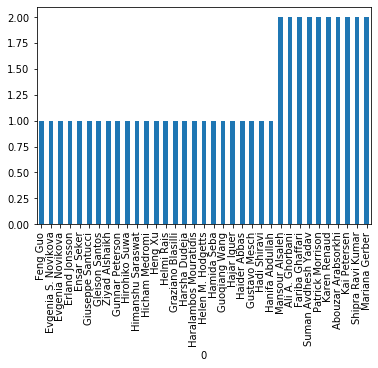

In [18]:
# Number of studies per author
# Most published authors
# extracting the authorcolumns from the df
auth_col_list = list(df.columns[:6])
authdf = pd.DataFrame(df[auth_col_list])
authindex = pd.DataFrame(authdf.stack())
authindex.groupby([0]).size().sort_values().tail(35).plot(kind='bar')
#auth_series = pd.Series(df[auth_col_list].values.ravel()).dropna()
#auth_series

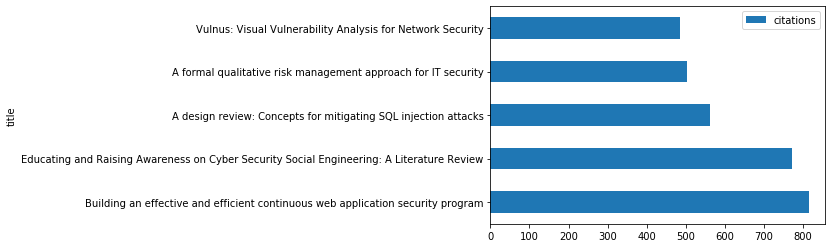

In [19]:
# Most cited paper plus distribution of citations
df[["citations", "title"]].sort_values(
    by="citations",
    ascending=False).head().set_index('title').plot(kind='barh')

In [20]:
df[["citations", "title"]].sort_values(by="citations",
                                      ascending=False)

,citations,title
126,817,Building an effective and efficient continuous...
130,773,Educating and Raising Awareness on Cyber Secur...
50,562,A design review: Concepts for mitigating SQL i...
76,503,A formal qualitative risk management approach ...
10,486,Vulnus: Visual Vulnerability Analysis for Netw...
...,...,...
141,1,An evaluation framework for network security v...
89,0,Trade secrets and cyber security breaches
16,0,Apparatus: A framework for security analysis i...
85,0,A control-theoretic perspective on cyber-physi...


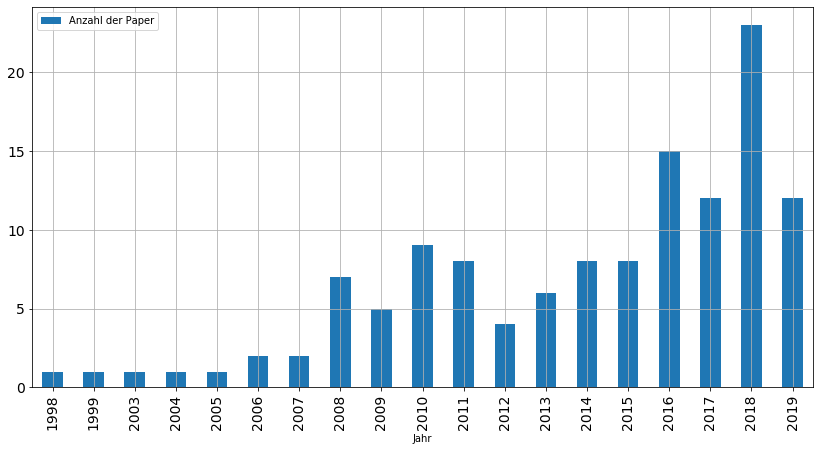

In [21]:
# Time series corelation. x: tiem in years, y: number of studies
time_correlation_gby = df.groupby("year").size()
time_corr_df = pd.DataFrame(time_correlation_gby)
time_corr_df.columns = ['Anzahl der Paper']
time_corr_df.index.name = 'Jahr'
time_corr_df.plot(kind='bar', figsize=(14, 7), grid=True, fontsize=14)

In [22]:
# Get a listing of published papers per yea
df.groupby("year").size().sort_values(ascending=False)

year
2018    23
2016    15
2019    12
2017    12
2010     9
2014     8
2011     8
2015     8
2008     7
2013     6
2009     5
2012     4
2007     2
2006     2
2005     1
2004     1
2003     1
1999     1
1998     1
dtype: int64

In [25]:
# 2010 stand out here, so have a look which Papers were published then
df.loc[df["year"] == 2010, ["year", "title", "database"]]

,year,title,database
15,2010,Why Measuring Security Is Hard,ieeexplore
34,2010,Information Security Threats Classification Py...,ieeexplore
77,2010,NetVis: A network security management visualiz...,ieeexplore
80,2010,A systematic review of security requirements e...,sciencedirect
91,2010,Vulnerability Analysis in SOA-Based Business P...,ieeexplore
93,2010,Introducing a framework for security measurements,ieeexplore
98,2010,An expert system for security diagnosing of co...,ieeexplore
123,2010,Expert-Aware Approach: A New Approach to Impro...,ieeexplore
139,2010,A Formal Approach Enabling Risk-Aware Business...,ieeexplore


In [26]:
database_by_year

NameError: name 'database_by_year' is not defined

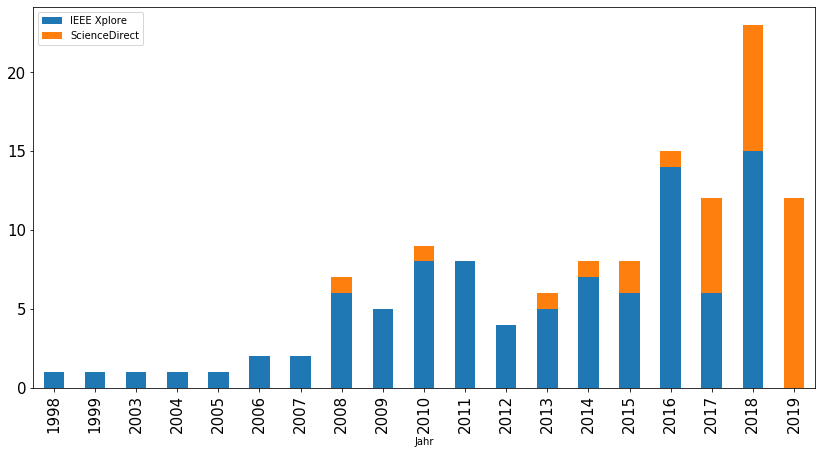

In [27]:
# Which are the most cited datqabases per year
index_names = ["Jahr", "Datenbank"]
grp_by_year_db = df.groupby(["year", "database"]).size()
grp_by_year_db.index.names = index_names
database_by_year = grp_by_year_db.unstack().fillna(0)
database_by_year.columns = ["IEEE Xplore", "ScienceDirect"]
database_by_year.plot(kind='bar', stacked=True, figsize=(14,7), fontsize=15)

In [28]:
database_by_year

,IEEE Xplore,ScienceDirect
Jahr,,
1998,1.0,0.0
1999,1.0,0.0
2003,1.0,0.0
2004,1.0,0.0
2005,1.0,0.0
2006,2.0,0.0
2007,2.0,0.0
2008,6.0,1.0
2009,5.0,0.0


In [ ]:
# Journal types. Journals of Conference

In [ ]:
# Most published journals. Dropping all values with NotaJournal entry
df.loc[df["journal"].eq('Proceedings Title: 2012 International Conference on Cyber Security, Cyber Warfare and Digital Forensic (CyberSec)'), "journal"] = "2012 International Conference on Cyber Security, Cyber Warfare and Digital Forensic"
journal_gby = df.groupby("journal").size().drop('NaJ').sort_values().tail(5)
journal_time_journal_df = journal_gby.reset_index()
journal_time_journal_df.columns = ["Journal", "Erschienene Paper pro Jahr"]
journal_time_journal_df.set_index("Journal").plot(kind='barh')
# journal_plot = journal_time_journal_df.set_index("Journal").plot(kind='barh')

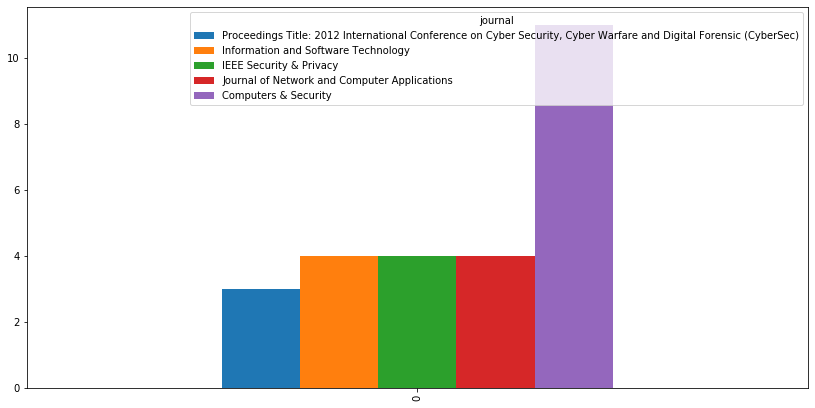

In [80]:
# Most published journals.

# Get the dataframe
# Get the amount of journals. Probably groupby
grp_journal = df.groupby("journal").size().drop('NaJ').sort_values().tail(5)
grp_journal_amount = pd.DataFrame(grp_journal.reset_index().unstack().unstack())
grp_journal_amount.columns = grp_journal_amount.loc["journal"]
grp_journal_amount.drop(grp_journal_amount.index[0]).plot(kind='bar', figsize=(14,7))

In [81]:
input_df = pd.DataFrame(grp_journal.reset_index())
new_cols = input_df["journal"].values
type(new_cols)

numpy.ndarray

,"Proceedings Title: 2012 International Conference on Cyber Security, Cyber Warfare and Digital Forensic (CyberSec)",Information and Software Technology,IEEE Security & Privacy,Journal of Network and Computer Applications,Computers & Security
0,3.0,NaN,NaN,NaN,NaN
1,NaN,4.0,NaN,NaN,NaN
2,NaN,NaN,4.0,NaN,NaN
3,NaN,NaN,NaN,4.0,NaN
4,NaN,NaN,NaN,NaN,11.0


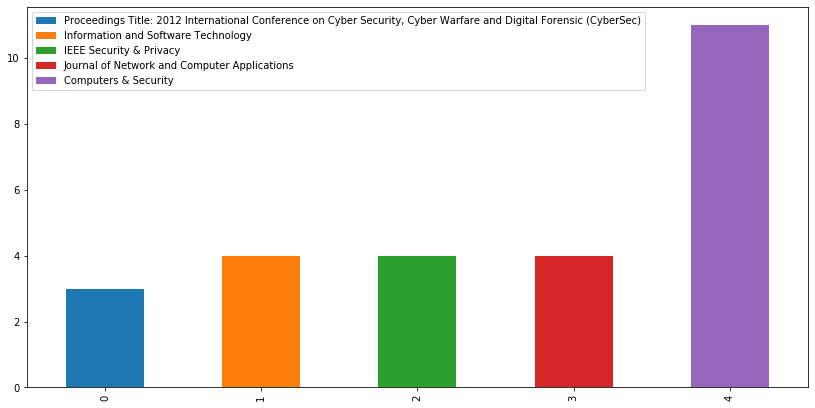

In [82]:
def values_into_main_diagonal(some_series, new_cols):
    """Puts the values of a series onto the main diagonal of a new df"""
    x = [{i: some_series[i]} for i in range(len(some_series))]
    main_diag_df = pd.DataFrame(x)
    main_diag_df.columns = new_cols
    return main_diag_df

# Saving the index for later new column labels
stack_df = pd.DataFrame(values_into_main_diagonal(input_df[0], new_cols))
stack_df.plot(kind='bar', stacked=True, figsize=(14,7))
stack_df

In [83]:
grp_j

NameError: name 'grp_j' is not defined

In [84]:
grp_journal_amount

journal,"Proceedings Title: 2012 International Conference on Cyber Security, Cyber Warfare and Digital Forensic (CyberSec)",Information and Software Technology,IEEE Security & Privacy,Journal of Network and Computer Applications,Computers & Security
journal,Proceedings Title: 2012 International Conferen...,Information and Software Technology,IEEE Security & Privacy,Journal of Network and Computer Applications,Computers & Security
0,3,4,4,4,11


In [85]:
# Stack Overflowquestion answer
s_df = pd.DataFrame(grp_journal.reset_index().unstack().unstack())
s_df
# Capturing the journals row
new_cols = s_df.values[0]
s_df.values





array([['Proceedings Title: 2012 International Conference on Cyber Security, Cyber Warfare and Digital Forensic (CyberSec)',
        'Information and Software Technology', 'IEEE Security & Privacy',
        'Journal of Network and Computer Applications',
        'Computers & Security'],
       [3, 4, 4, 4, 11]], dtype=object)

In [86]:
def values_to_main_diagonal(one_row_df, column_labels):
    """Returns a Dataframe, were the values from a """
    x = [{i: one_row_df.values[0][i]} for i in range(len(one_row_df.columns))]
    main_diagonal_df = pd.DataFrame(x)
    main_diagonal_df.columns = column_labels
    
one_row_df = grp_journal_amount.drop(grp_journal_amount.index[0])
one_row_cols = one_row_df.columns
x_df = values_to_main_diagonal(one_row_df)

#main_diagonal_df = pd.DataFrame(x)
#main_diagonal_df.columns = one_row_cols
#main_diagonal_df.plot(kind='bar', stacked=True, figsize=(14,7))


TypeError: values_to_main_diagonal() missing 1 required positional argument: 'column_labels'

In [ ]:
list(range(5))

In [ ]:
# Found papers in databases
used_databases = df["database"].value_counts()
used_databases.plot(kind='bar')

In [ ]:
used_databases.to_csv('test.csv')

In [ ]:
# Found conference papers. Usually withour an impact factor

In [ ]:
# Shows impact factors and journals that are most commonly used
df.groupby(["impact_factor", "journal"]).size().drop(0.000).sort_values().tail(
10).plot(kind='barh')

In [ ]:
# Show highest impactfactors and journals used
# df.loc[:, ["journal", "impact_factor"]].sort_values(by="impact_factor").tail(18)
df.groupby("impact_factor").size().drop(0.000).sort_values().plot(kind='barh')

In [ ]:
import random

In [ ]:
x = [{i:random.randint(1,10)} for i in range(6)]
tdf = pd.DataFrame(x)
tdf.plot(kind='bar', stacked=True)

In [ ]:
tdf

,author0,author1,author2,author3,author4,author5,keywords0,keywords1,keywords10,keywords11,...,keywords6,keywords7,keywords8,keywords9,database,title,journal,citations,year,impact_factor
0,Reijo M. Savola,Petri Heinonen,NaN,NaN,NaN,NaN,Measurement,Visualization,NaN,NaN,...,security metrics,visualization,security assurance,risk management,ieeexplore,A visualization and modeling tool for security...,2011 Information Security for South Africa,10,2011,0.000
1,Mariana Gerber,Rossouw von Solms,NaN,NaN,NaN,NaN,Information security,Information security management,NaN,NaN,...,Compliance,NaN,NaN,NaN,sciencedirect,Information security requirements – Interpreti...,Computers & Security,21,2008,3.062
2,Cyril Onwubiko,NaN,NaN,NaN,NaN,NaN,Monitoring,Business,CyberSA,Log Source,...,CSOC,SOC,Cyber Incident Response,Cyber Situational Awareness,ieeexplore,Cyber security operations centre: Security mon...,2015 International Conference on Cyber Situati...,6,2015,0.000
4,Patrick Morrison,David Moye,Rahul Pandita,Laurie Williams,NaN,NaN,Metrics,Measurement,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Mapping the field of software life cycle secur...,Information and Software Technology,3,2018,2.921
5,S. Lipner,NaN,NaN,NaN,NaN,NaN,Computer security,Application software,NaN,NaN,...,NaN,NaN,NaN,NaN,ieeexplore,The trustworthy computing security development...,20th Annual Computer Security Applications Con...,47,2004,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Minhaj Ahmad Khan,NaN,NaN,NaN,NaN,NaN,Cloud security,Cloud computing,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,A survey of security issues for cloud computing,Journal of Network and Computer Applications,77,2016,5.273
138,Seraj Fayyad,Josef Noll,NaN,NaN,NaN,NaN,Security,Measurement,security measurability,security evaluation,...,Communication systems,Internet of Things,Multi-Metrics,security enhancement,ieeexplore,A framework for measurability of security,2017 8th International Conference on Informati...,1,2017,0.000
139,Simon Tjoa,Stefan Jakoubi,Gernot Goluch,Gerhard Kitzler,Sigrun Goluch,Gerald Quirchmayr,Security,Unified modeling language,NaN,NaN,...,Business process reengineering,consulting and strategic planning,security enablement methods and tools.,NaN,ieeexplore,A Formal Approach Enabling Risk-Aware Business...,IEEE Transactions on Services Computing,15,2010,5.707
140,Abdullah Almubark,Nobutoshi Hatanaka,Osamu Uchida,Yukiyo Ikeda,NaN,NaN,Decision support systems,Information security,NaN,NaN,...,NaN,NaN,NaN,NaN,ieeexplore,The effectiveness of corporate culture toward ...,2015 World Congress on Information Technology ...,133,2015,0.000
